Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
!

---

# PyRobot Grasp Sampler (a.k.a. Patch-Grasp)

This is a colab version of the PyRobot Grasping example using a learned model. Note that only partial dependencies are installed to run minimal demostrations.

https://github.com/facebookresearch/pyrobot/tree/master/examples/grasping

## Installation and Setup

### Import Modules

In [1]:
import sys
import os
import os.path

#from google.colab import drive
#import gdown
from zipfile import ZipFile

import copy
import numpy as np
import cv2

import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

import errno
import time

ImportError: No module named gdown

### Path Setup

The code we will use today is at: https://github.com/Sensing-Intelligent-System/pyrobot/tree/master/examples/grasping/grasp_samplers

Download repo to use the files examples/grasping/grasp_samplers

In [2]:
sys.path.append('/home/isci/ICT-example/third_party/grasp_samplers')
print(sys.path)

['', '/opt/ros/melodic/lib/python2.7/dist-packages', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/home/isci/.ipython', '/home/isci/ICT-example/third_party/grasp_samplers']


In [12]:
# !git clone https://github.com/Sensing-Intelligent-System/pyrobot.git

# sys.path.append('/home/isci/ICT-example/catkin_ws/src/colab_file/pyrobot/examples/grasping/grasp_samplers')
# print(sys.path)

fatal: destination path 'pyrobot' already exists and is not an empty directory.
['', '/opt/ros/kinetic/lib/python2.7/dist-packages', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/usr/local/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages/PILcompat', '/usr/lib/python2.7/dist-packages/gtk-2.0', '/usr/lib/python2.7/dist-packages/wx-3.0-gtk2', '/usr/local/lib/python2.7/dist-packages/IPython/extensions', '/home/isci/.ipython', '/home/isci/ICT-example/catkin_ws/src/colab_file/pyrobot/examples/grasping/grasp_samplers', '/home/isci/ICT-example/catkin_ws/src/colab_file/pyrobot/examples/grasping/grasp_samplers']


## Prepare and Visualize for Data

### Download Test Images

In [6]:
# dataset_url = 'https://drive.google.com/u/1/uc?id=1G0eNpR9jx-X33DiQKcT3FrwFp0cm9433&export=download'
# dataset_name = 'demo'
# if not os.path.isdir(dataset_name):
#     gdown.download(dataset_url, output=dataset_name + '.zip', quiet=False)
#     zip1 = ZipFile('/home/isci/ICT-example/catkin_ws/src/colab_file/demo' + '.zip')
#     zip1.extractall('/home/isci/ICT-example/catkin_ws/src/colab_file')
#     zip1.close()

# print("Finished downloading demo dataset.")

Downloading...
From: https://drive.google.com/u/1/uc?id=1G0eNpR9jx-X33DiQKcT3FrwFp0cm9433&export=download
To: /home/isci/ICT-example/catkin_ws/src/colab_file/demo.zip
100%|██████████| 104k/104k [00:00<00:00, 13.6MB/s]

Finished downloading demo dataset.


### Visualize Test Images

Each image is a "patch," which will be scaled to 224 by 224.

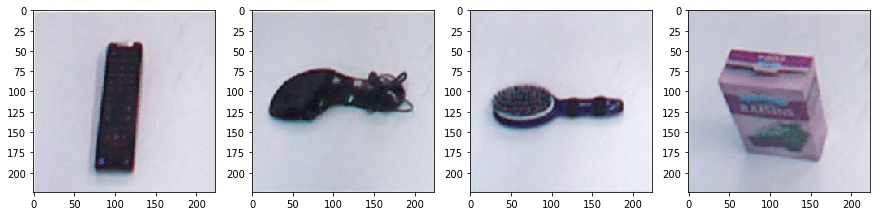

In [3]:
# index = ['1', '2', '3', '4']
# data = []
# for name in index:
#   img = cv2.imread('/home/isci/ICT-example/third_party/grasp_samplers/demo_images/'+name+'.jpg')[:,:,[2, 1, 0]]
#   img = cv2.resize(img, (224, 224))
#   data.append(img)

# fig , ax = plt.subplots(figsize=(15, 15))
# for i in range(4):
#   plt.subplot(1, 4, i+1)
#   plt.imshow(data[i][:,:,[2, 1, 0]])

### drawRectangle

We need a visualizattion function drawTectangle here.

In [10]:
# !awk 'NR>=52 && NR<=73' /home/isci/ICT-example/third_party/grasp_samplers/grasp_model.py

def drawRectangle(I, h, w, t, gsize=300):
    """
    Function to draw a grasp rectangle on an image.

    :param I: Image on which the grasp will be drawn on
    :param h: height index for the center of grasp
    :param w: width index for the center of grasp
    :param t: grasp angle number of the grasp
    :param gsize: size of the grasp
    :type I: np.ndarray
    :type h: int
    :type w: int
    :type t: int
    :type gsize: int

    :returns: Image with grasp rectangle drawn on it
    :rtype: np.ndarray
    """
    I_temp = I
    grasp_l = gsize / 2.5
    grasp_w = gsize / 5.0
    grasp_angle = t * (np.pi / 18) - np.pi / 2


In [3]:
def drawRectangle(I, h, w, t, gsize=300):
    """
    Function to draw a grasp rectangle on an image.
    :param I: Image on which the grasp will be drawn on
    :param h: height index for the center of grasp
    :param w: width index for the center of grasp
    :param t: grasp angle number of the grasp
    :param gsize: size of the grasp
    :type I: np.ndarray
    :type h: int
    :type w: int
    :type t: int
    :type gsize: int
    :returns: Image with grasp rectangle drawn on it
    :rtype: np.ndarray
    """
    I_temp = I
    grasp_l = gsize / 2.5
    grasp_w = gsize / 5.0
    grasp_angle = t * (np.pi / 18) - np.pi / 2

    points = np.array(
        [
            [-grasp_l, -grasp_w],
            [grasp_l, -grasp_w],
            [grasp_l, grasp_w],
            [-grasp_l, grasp_w],
        ]
    )
    R = np.array(
        [
            [np.cos(grasp_angle), -np.sin(grasp_angle)],
            [np.sin(grasp_angle), np.cos(grasp_angle)],
        ]
    )
    rot_points = np.dot(R, points.transpose()).transpose()
    im_points = rot_points + np.array([w, h])
    cv2.line(
        I_temp,
        tuple(im_points[0].astype(int)),
        tuple(im_points[1].astype(int)),
        color=(0, 255, 0),
        thickness=5,
    )
    cv2.line(
        I_temp,
        tuple(im_points[1].astype(int)),
        tuple(im_points[2].astype(int)),
        color=(0, 0, 255),
        thickness=5,
    )
    cv2.line(
        I_temp,
        tuple(im_points[2].astype(int)),
        tuple(im_points[3].astype(int)),
        color=(0, 255, 0),
        thickness=5,
    )
    cv2.line(
        I_temp,
        tuple(im_points[3].astype(int)),
        tuple(im_points[0].astype(int)),
        color=(0, 0, 255),
        thickness=5,
    )
    return I_temp

## Prepare for Model

The model will be downloaded from the internet source provided as in the pyrobot code.
A copy is available in the pretrained-model folder in case the source is unavailable.

### Overview

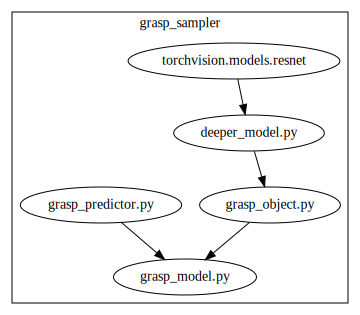

In [ ]:
# from graphviz import Digraph

# locobot_graph = Digraph(format='png')

# with locobot_graph.subgraph(name='cluster_0') as sampler:
#   sampler.attr(label='grasp_sampler')
#   sampler.node('torchvision.models.resnet', 'torchvision.models.resnet')
#   sampler.node('deeper_model', 'deeper_model.py')
#   sampler.node('grasp_object', 'grasp_object.py')
#   sampler.node('grasp_model', 'grasp_model.py')
#   sampler.node('grasp_predictor', 'grasp_predictor.py')

#   locobot_graph.edge('torchvision.models.resnet', 'deeper_model')
#   locobot_graph.edge('deeper_model', 'grasp_object')
#   locobot_graph.edge('grasp_object', 'grasp_model')
#   locobot_graph.edge('grasp_predictor', 'grasp_model')

# locobot_graph

### Download pre-trained weights

Here is a trick to read a section of code. Just to explain where the code is. The reader could also check what have been modified.

In [12]:
# !awk 'NR>=32 && NR<=50' /home/isci/ICT-example/third_party/grasp_samplers/grasp_model.py

def download_if_not_present(model_path, url):
    """
    Function that downloads a file from a url to a given location.

    :param model_path: Path where the file should be downlaoded to
    :param url: URL from where the file will be downloaded from
    :type model_path: string
    :type url: string
    """
    if not os.path.isfile(model_path):
        if not os.path.exists(os.path.dirname(model_path)):
            try:
                os.makedirs(os.path.dirname(model_path))
            except OSError as exc:  # Guard against race condition
                if exc.errno != errno.EEXIST:
                    raise
        print("GRASP MODEL NOT FOUND! DOWNLOADING IT!")
        os.system("wget {} -O {}".format(url, model_path))



In [ ]:
# def download_if_not_present(model_path, url):
#     """
#     Function that downloads a file from a url to a given location.
#     :param model_path: Path where the file should be downlaoded to
#     :param url: URL from where the file will be downloaded from
#     :type model_path: string
#     :type url: string
#     """
#     if not os.path.isfile(model_path):
#         if not os.path.exists(os.path.dirname(model_path)):
#             try:
#                 os.makedirs(os.path.dirname(model_path))
#             except OSError as exc:  # Guard against race condition
#                 if exc.errno != errno.EEXIST:
#                     raise
#         print("GRASP MODEL NOT FOUND! DOWNLOADING IT!")
#         os.system("wget {} -O {}".format(url, model_path))

# download_if_not_present('/content/model.pth',url='https://www.dropbox.com/s/fta8zebyzfrt3fw/checkpoint.pth.20?dl=0')

GRASP MODEL NOT FOUND! DOWNLOADING IT!


### deeper_models.py

In [13]:
# !awk 'NR>=6 && NR<=32' /home/isci/ICT-example/third_party/grasp_samplers/deeper_models.py

import torch
import torch.utils.model_zoo as model_zoo
from torch import nn
from torchvision.models.resnet import ResNet, BasicBlock, model_urls

n_class = 18
n_images = 9
n_robots = 5


class IfullRobHWNet(ResNet):
    def __init__(
        self,
        h_size=128,
        out_size=n_class,
        noise_size=n_images,
        pretrained_resnet18=True,
        fixed_feature=False,
        **kwargs
    ):
        super(IfullRobHWNet, self).__init__(BasicBlock, [2, 2, 2, 2])
        if pretrained_resnet18:
            self.load_from_pretrained_resnet18()
        if fixed_feature:
            print("FIXING RESNET PARAMETERS")
            for param in self.parameters():
                param.requires_grad = False


### grasp_object.py

grasp_object.py contains a class with functionality to wrap a torch grasp model with testing operations.


In [14]:
# !awk 'NR>=29 && NR<=51' /home/isci/ICT-example/third_party/grasp_samplers/grasp_object.py

class GraspTorchObj(object):
    """
    This class contains functionality to wrap a torch grasp model with testing operations.
    """

    def __init__(self, model_path, transform=None):
        """
            The constructor for :class:`GraspTorchObj` class.
    
            :param model_path: Path where the grasp model should be loaded from
            :param transform: A PyTorch transform that gets applied on the input
            :type model_path: string
            :type transform: A torchvision.Transform object
            """
        torch.nn.Module.dump_patches = True
        self.model = torch.load(model_path).eval()
        self.image_size = 224
        if is_gpu:
            self.model = self.model.cuda()
        if transform is None:
            self.transform = self.get_default_transform()
        else:
            self.transform = transform


In [15]:
# def recursion_change_bn(module):
#     if isinstance(module, torch.nn.BatchNorm2d):
#         module.track_running_stats = 1
#     else:
#         for i, (name, module1) in enumerate(module._modules.items()):
#             module1 = recursion_change_bn(module1)
#     return module

In [4]:
import deeper_models

sys.modules["patch_learner.deeper_models"] = deeper_models
sys.modules["patch_learner"] = deeper_models

is_gpu = torch.cuda.is_available()
n_class = 18
n_rob = 5

from grasp_object import GraspTorchObj

In [21]:
# import deeper_models

# sys.modules["patch_learner.deeper_models"] = deeper_models
# sys.modules["patch_learner"] = deeper_models

# is_gpu = torch.cuda.is_available()
# n_class = 18
# n_rob = 5

# class GraspTorchObj(object):
#     """
#     This class contains functionality to wrap a torch grasp model with testing operations.
#     """

#     def __init__(self, model_path, transform=None):
#         """
#             The constructor for :class:`GraspTorchObj` class.
    
#             :param model_path: Path where the grasp model should be loaded from
#             :param transform: A PyTorch transform that gets applied on the input
#             :type model_path: string
#             :type transform: A torchvision.Transform object
#             """
#         torch.nn.Module.dump_patches = True
# #         self.model = torch.load(model_path).eval()
#         check_point = torch.load(model_path)
#         self.model = check_point
#         for i, (name, module) in enumerate(self.model._modules.items()):
#             module = self.recursion_change_bn(self.model)
#         self.model.eval()
# #         end of transform
#         self.model.avgpool = nn.AdaptiveAvgPool2d((1,1))
#         self.image_size = 224
#         if is_gpu:
#             self.model = self.model.cuda()
#         if transform is None:
#             self.transform = self.get_default_transform()
#         else:
#             self.transform = transform

#     def test_one_batch(self, x, h, w, angle_labels, robot_labels, full_x):
#         """
#         Runs the torch model on a batch of inputs.
    
#             :param x: List of image patches
#             :param h: List of heights of the center of the patch in the original image
#             :param w: List of widths of the center of the patch in the original image
#             :param angle_labels: List of labels corresponding to the angle to grasp
#             :param robot_labels: List of robot_id corresponding to the robot
#             :param full_x: List of original image where the patch comes from.
#             :type x: list
#             :type h: list
#             :type w: list
#             :type angle_labels: list
#             :type robot_labels: list
#             :type full_x: list
    
#             :returns: List of grasp predictions
#             :rtype: list
#         """
#         torch_patches_var = Variable(self.convert_cv2_patches(x))
#         h_var = Variable(self.convert_hw(h))
#         w_var = Variable(self.convert_hw(w))
#         one_hot_var = self.convert_one_hot(angle_labels)
#         #print(angle_labels)
#         #print(one_hot_var)

#         robot_one_hot_var = self.convert_robot_one_hot(robot_labels)
#         #print(robot_labels)
#         #print(robot_one_hot_var)
        
#         torch_images_var = Variable(self.convert_cv2_patches(full_x))

#         if is_gpu:
#             torch_patches_var = torch_patches_var.cuda()
#             h_var = h_var.cuda()
#             w_var = w_var.cuda()
#             one_hot_var = one_hot_var.cuda()
#             robot_one_hot_var = robot_one_hot_var.cuda()
#             torch_images_var = torch_images_var.cuda()
#         predictions, _ = self.model(
#             x=torch_patches_var,
#             h=h_var,
#             w=w_var,
#             one_hot_labels=one_hot_var,
#             robot_one_hot_labels=robot_one_hot_var,
#             full_x=torch_images_var,
#         )
#         return predictions.data.cpu().numpy()

#     def convert_cv2_patches(self, P):
#         """
#         Converts a list of image patches to a torch Tensor
    
#         :param P: List of image patches
#         :type P: list
    
#         :returns: A torch Tensor of image patches
#         :rtype: torch Tensor
#         """
#         assert len(P.shape) == 4
#         im_list = []
#         for p in P:
#             p = np.uint8(p)
#             pil_im = Image.fromarray(p)
#             pil_im = pil_im.convert("RGB")
#             if self.transform:
#                 pil_im = self.transform(pil_im)
#             im_list.append(pil_im)
#         im_stacked = torch.stack(im_list)
#         return im_stacked

#     def convert_hw(self, h):
#         """
#         Converts a list of floats to a torch Tensor
    
#         :param h: List of floats
#         :type h: list
    
#         :returns: A torch FloatTensor
#         :rtype: torch FloatTensor
#         """
#         return torch.FloatTensor(h)

#     def convert_one_hot(self, labels):
#         """
#         Converts a list of grasp angle labels to a Torch tensor of one_hot labels
    
#         :param labels: List of angle labels
#         :type labels: list
    
#         :returns: A torch tensor of one_hot labels
#         :rtype: torch Tensor
#         """
#         batch_size = len(labels)
#         labels_tensor = Variable(torch.LongTensor(labels))
#         y_onehot = Variable(torch.DoubleTensor(batch_size, n_class))
#         y_onehot.zero_()
#         labels_onehot = y_onehot.scatter_(1, labels_tensor.view(-1, 1), 1)
#         return labels_onehot

#     def convert_robot_one_hot(self, labels):
#         """
#         Converts a list of robot_id labels to a Torch tensor of one_hot labels
    
#         :param labels: List of robot_id labels
#         :type labels: list
    
#         :returns: A torch tensor of one_hot labels
#         :rtype: torch Tensor
#         """
#         batch_size = len(labels)
#         labels_tensor = Variable(torch.LongTensor(labels))
#         y_onehot = Variable(torch.DoubleTensor(batch_size, n_rob))
#         y_onehot.zero_()
#         labels_onehot = y_onehot.scatter_(1, labels_tensor.view(-1, 1), 1)
#         return labels_onehot

#     def get_default_transform(self):
#         """
#         Return the default transform to be applied on the images. This corresponds to the transform that was applied to the images during training.
    
#         :returns: An image transform
#         :rtype: a torchvision.Transform object
#         """
#         image_transforms = transforms.Compose(
#             [
#                 transforms.Resize((self.image_size, self.image_size)),
#                 transforms.ToTensor(),
#                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#             ]
#         )
#         return image_transforms
    
#     def recursion_change_bn(self, module):
#         if isinstance(module, torch.nn.BatchNorm2d):
#             module.track_running_stats = 1
#         else:
#             for i, (name, module1) in enumerate(module._modules.items()):
#                 module1 = self.recursion_change_bn(module1)
#         return module

### grasp_predictor.py

Given image, returns image point and theta to grasp.

Here we only only do the prediction for patches. We did not tackle the parts getting patches from scene image.

In [18]:
# !awk 'NR>=29 && NR<=45' /home/isci/ICT-example/third_party/grasp_samplers/grasp_predictor.py

class Predictors:
    """
    This class contains functionality to sample grasp patches from the scene image.
    """

    def __init__(self, img, grasp_obj=None):
        """
        The constructor for :class:`Predictors` class.
    
            :param img: An image of the scene
            :param grasp_obj: An object that contains grasp model operations
            :type img: np.ndarray
            :type grasp_obj: GraspTorchObj
        """
        self.img = img
        self.img_h, self.img_w, self.img_c = self.img.shape
        self.grasp_obj = grasp_obj


In [5]:
n_class = 18
min_patch_std = 1
angle_dependence = [0.25, 0.5, 0.25]

try:
    xrange
except NameError:
    xrange = range


# Given image, returns image point and theta to grasp
class Predictors:
    """
    This class contains functionality to sample grasp patches from the scene image.
    """

    def __init__(self, img, grasp_obj=None):
        """
        The constructor for :class:`Predictors` class.
    
            :param img: An image of the scene
            :param grasp_obj: An object that contains grasp model operations
            :type img: np.ndarray
            :type grasp_obj: GraspTorchObj
        """
        self.img = img
        self.img_h, self.img_w, self.img_c = self.img.shape
        self.grasp_obj = grasp_obj

    def random_grasp(self):
        """
        Samples a random grasp configuration.
    
        :returns: A grasp configuration (height, width, angle) of a random grasp
        :rtype: tuple
        """
        h_g = np.random.randint(self.img_h)
        w_g = np.random.randint(self.img_w)
        t_g = np.random.randint(n_class)
        return h_g, w_g, t_g

    def center_grasp(self):
        """
        Select the center grasp configuration.
    
        :returns: A grasp configuration (height, width, angle) of the center grasp
        :rtype: tuple
        """
        h_g = np.int(self.img_h / 2)
        w_g = np.int(self.img_w / 2)
        t_g = np.int(n_class / 2)
        return h_g, w_g, t_g

    def graspNet_grasp(self, patch_size=300, num_samples=128):
        """
        Select grasp based on the grasp model.
    
        :param patch_size: Size of patch to be sampled
        :param num_samples: Number of patches to run
        :type patch_size: int
        :type num_samples: int
        """
        self.patch_size = patch_size
        half_patch_size = np.int(patch_size / 2) + 1
        h_range = self.img_h - patch_size - 2
        w_range = self.img_w - patch_size - 2

        # Initialize random patch points
        patch_hs = np.random.randint(h_range, size=num_samples) + half_patch_size
        patch_ws = np.random.randint(w_range, size=num_samples) + half_patch_size

        patch_Is = np.zeros((num_samples, patch_size, patch_size, self.img_c))
        patch_Is_resized = np.zeros(
            (
                num_samples,
                self.grasp_obj.image_size,
                self.grasp_obj.image_size,
                self.img_c,
            )
        )
        for looper in xrange(num_samples):
            isWhiteFlag = 1
            while isWhiteFlag == 1:
                patch_hs[looper] = np.random.randint(h_range) + half_patch_size
                patch_ws[looper] = np.random.randint(w_range) + half_patch_size
                h_b = patch_hs[looper] - half_patch_size
                w_b = patch_ws[looper] - half_patch_size
                patch_Is[looper] = self.img[
                    h_b : h_b + patch_size, w_b : w_b + patch_size
                ]
                # Make sure that the input has a minimal
                # amount of standard deviation from mean. If
                # not resample
                if patch_Is[looper].std() > min_patch_std:
                    isWhiteFlag = 0
                else:
                    isWhiteFlag = 1
            patch_Is_resized[looper] = cv2.resize(
                patch_Is[looper],
                (self.grasp_obj.image_size, self.grasp_obj.image_size),
                interpolation=cv2.INTER_CUBIC,
            )
        angle_labels = [0 for _ in patch_Is_resized]
        robot_labels = [0 for _ in patch_Is_resized]
        full_x = np.array([self.img for _ in patch_Is_resized])
        param_dict = {
            "x": patch_Is_resized,
            "h": patch_hs,
            "w": patch_ws,
            "angle_labels": angle_labels,
            "robot_labels": robot_labels,
            "full_x": full_x,
        }
        self.vals = self.grasp_obj.test_one_batch(**param_dict)

        # Normalizing angle uncertainity
        wf = angle_dependence
        self.norm_vals = copy.deepcopy(self.vals)
        for looper in xrange(num_samples):
            for norm_looper in xrange(n_class):
                n_val = (
                    wf[1] * self.norm_vals[looper, norm_looper]
                    + wf[0] * self.norm_vals[looper, (norm_looper - 1) % n_class]
                    + wf[2] * self.norm_vals[looper, (norm_looper + 1) % n_class]
                )
                self.norm_vals[looper, norm_looper] = n_val
        self.patch_hs = patch_hs
        self.patch_ws = patch_ws
        self.patch_Is_resized = patch_Is_resized

### grasp_model.py

Here finally we could put them together in GarspModel calss

In [20]:
# !awk 'NR>=122 && NR<=150' /home/isci/ICT-example/third_party/grasp_samplers/grasp_model.py

class GraspModel(object):
    """
    This class contains functionality for grasp prediction.
    """

    def __init__(
        self,
        nsamples=128,
        patchsize=50,
        n_importance=1,
        n_sen=0,
        n_sen_samples=0,
        sen_pixels=0,
        sen_metric="mean",
        model_name=None,
        url=None,
    ):
        """
            The constructor for :class:`GraspModel` class.

            :param nsamples: Number of samples from a given image
            :param patchsize: Size of patch to be sampled
            :param n_importance: Number of importance samples
            :param n_sen: Number of patches to perform sensitivity on
            :param n_sen_samples: Number of samples for each patch
            :param sen_pixels: Number of pixels to compute sensitivity over
        :param sen_metric: Metric for sensitivity aggregation
            :param model_name: Name of the downloaded model
        :param url: URL for the model


In [6]:
GPU_ID = -1
MAX_BATCHSIZE = 20

class GraspModel(object):
    """
    This class contains functionality for grasp prediction.
    """

    def __init__(
        self,
        nsamples=128,
        patchsize=50,
        n_importance=1,
        n_sen=0,
        n_sen_samples=0,
        sen_pixels=0,
        sen_metric="mean",
        model_name=None,
        url=None,
    ):
        """
            The constructor for :class:`GraspModel` class.
            :param nsamples: Number of samples from a given image
            :param patchsize: Size of patch to be sampled
            :param n_importance: Number of importance samples
            :param n_sen: Number of patches to perform sensitivity on
            :param n_sen_samples: Number of samples for each patch
            :param sen_pixels: Number of pixels to compute sensitivity over
        :param sen_metric: Metric for sensitivity aggregation
            :param model_name: Name of the downloaded model
        :param url: URL for the model
            :type nsamples: int
            :type patchsize: int
            :type n_importance: int
            :type n_sen: int
            :type n_sen_samples: int
            :type sen_pixels: int
            :type sen_metric: string
            :type model_name: string
            :type url: string
            """

        model_path = '/home/isci/ICT-example/third_party/grasp_samplers/models/model.pth'
        if nsamples > MAX_BATCHSIZE:
            self._batch_size = MAX_BATCHSIZE
            self._nbatches = int(nsamples / MAX_BATCHSIZE) + 1
        else:
            self._batch_size = nsamples
            self._nbatches = 1
        print("Loading grasp model")
        st_time = time.time()
        self.grasp_obj = GraspTorchObj(model_path)
        print("Time taken to load model: {}s".format(time.time() - st_time))
        self.patchsize = patchsize
        self.n_importance = n_importance
        self.n_sen = n_sen
        self.n_sen_samples = n_sen_samples
        self.sen_pixels = sen_pixels
        self.sen_metric = sen_metric
        self.sen_metrics = ["mean", "min"]
        assert self.sen_metric in self.sen_metrics
        assert self.n_sen_samples <= MAX_BATCHSIZE
        print('OKKKKKKKKKK')

    def predict(self, I):
        """
        Runs prediction on a given image.
        :param I: An image
        :type I: np.ndarray
        :returns: selected grasp configuration (height, width, angle, confidence)
        :rtype: tuple
        """
        start_time = time.time()

        # First round of forward pass
        result = self._predict_image(I, self._nbatches, self._batch_size)
        init_predictions, init_patch_Hs, init_patch_Ws = result

        # Predicting for second round of sensitivity
        sen_study = []
        sen_options = []
        if self.n_sen <= 0:
            predictions, patch_Hs, patch_Ws = (
                init_predictions,
                init_patch_Hs,
                init_patch_Ws,
            )
        else:
            im_shape = I.shape
            r = np.argsort(np.max(init_predictions, 1))
            r_best = r[-self.n_sen :][::-1]
            for r_ind in r_best:
                patch_h = init_patch_Hs[r_ind]
                patch_w = init_patch_Ws[r_ind]
                scan_size = self.patchsize + self.sen_pixels
                scan_halfsize = int(scan_size / 2)
                scan_region = [
                    patch_h - scan_halfsize,
                    patch_h + scan_halfsize,
                    patch_w - scan_halfsize,
                    patch_w + scan_halfsize,
                ]
                if (
                    scan_region[0] < 0
                    or scan_region[1] >= im_shape[0]
                    or scan_region[2] < 0
                    or scan_region[3] >= im_shape[1]
                ):
                    continue
                else:
                    I_hw = I[
                        scan_region[0] : scan_region[1], scan_region[2] : scan_region[3]
                    ]
                    result = self._predict_image(I_hw, 1, self.n_sen_samples)
                    hw_predictions, hw_patch_Hs, hw_patch_Ws = result
                    sen_study.append(copy([hw_predictions, hw_patch_Hs, hw_patch_Ws]))
                    sen_options.append(r_ind)
            if len(sen_options) == 0:
                predictions = init_predictions
                patch_Hs = init_patch_Hs
                patch_Ws = init_patch_Ws
            else:
                stability = []
                for option in sen_study:
                    if self.sen_metric == "mean":
                        stability.append(option[0].mean(0))
                    elif self.sen_metric == "min":
                        stability.append(option[0].min(0))
                stability = np.array(stability)
                predictions = copy(stability)
                patch_Hs = init_patch_Hs[sen_options]
                patch_Ws = init_patch_Ws[sen_options]

        # Importance Sampling
        r = np.argsort(np.max(predictions, 1))
        r_best = r[-self.n_importance :][::-1]
        imp_best = np.max(predictions, 1)[r_best]
        imp_best[imp_best < 0] = 0.0
        if imp_best[0] != 0.0:
            imp_best = imp_best / imp_best.sum()
            patch_choice_ind = np.random.choice(self.n_importance, p=imp_best)
            patch_ind = r_best[patch_choice_ind]
        else:
            patch_ind = r_best[0]
        theta_imps = copy.deepcopy(predictions[patch_ind])
        theta_imps[theta_imps < 0] = 0.0
        theta_choice_ind = np.argmax(theta_imps)
        grasp_angle = theta_choice_ind * (np.pi / 18) - np.pi / 2
        selected_grasp = (
            patch_Hs[patch_ind],
            patch_Ws[patch_ind],
            grasp_angle,
            predictions[patch_ind, theta_choice_ind],
        )
        self._disp_I = drawRectangle(
            I,
            selected_grasp[0],
            selected_grasp[1],
            theta_choice_ind,
            int(self.patchsize),
        )
        return selected_grasp

    def _predict_image(self, I, nbs, bs):
        """
        Compute raw network predictions
        :param I: Scene image
        :param nbs: Number of batches
        :param bs: Batch size
        :type I: np.ndarray
        :type nbs: int
        :type bs: int
        :returns: Grasp predictions
        :rtype: tuple
        """
        min_imsize = min(I.shape[:2])
        assert self.patchsize < min_imsize, "Input image dimensions are too small"
        gsize = int(self.patchsize)
        P = Predictors(I, self.grasp_obj)
        predictions = []
        patch_Hs = []
        patch_Ws = []
        for _ in range(nbs):
            P.graspNet_grasp(patch_size=gsize, num_samples=bs)
            predictions.append(P.norm_vals)
            patch_Hs.append(P.patch_hs)
            patch_Ws.append(P.patch_ws)

        predictions = np.concatenate(predictions)
        patch_Hs = np.concatenate(patch_Hs)
        patch_Ws = np.concatenate(patch_Ws)
        return predictions, patch_Hs, patch_Ws

    def display_predicted_image(self):
        """
        Display the scene image with the predicted grasp
        """
        if self._disp_I is None:
            return False
        print('Visualizing grasp; hit "space" to continue')
        image = cv2.cvtColor(self._disp_I, cv2.COLOR_BGR2RGB)[:,:,[2,1,0]]
        # plt.imshow(image)

        return image

    def save_predicted_image(self, img_fname):
        """
        Save predicted grasp on the image
        :param img_fname: Path of image file where the grasp should be saved
        :type img_fname: string
        """
        if self._disp_I is None:
            return
        cv2.imwrite(img_fname, self._disp_I)

### Exercise: Prediction on CPU or GPU (2 Points)

You could use different runtime to examine the time needed to compute grasps for the 4 demo patch images.

CPU: 1-2 minutes
GPU: 2.88 sec

In [7]:
is_gpu = torch.cuda.is_available()
print(is_gpu)

True


In [8]:
def run_prediction(data):

  result = []
  G = GraspModel()
  for i in data:
    G.predict(i)
    result.append([G.display_predicted_image(), G.predict(i)])
  
  return result

Loading grasp model


/usr/local/lib/python2.7/dist-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'deeper_models.IfullRobHWNet' has changed. Tried to save a patch, but couldn't create a writable file IfullRobHWNet.patch. Make sure it doesn't exist and your working directory is writable.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python2.7/dist-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. Tried to save a patch, but couldn't create a writable file Conv2d.patch. Make sure it doesn't exist and your working directory is writable.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python2.7/dist-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. Tried to save a patch, but couldn't create a writable file BatchNorm2d.patch. Make sure it doesn't exist and your working directory is writable.
  warnings.warn(

Time taken to load model: 1.15550017357s
OKKKKKKKKKK


/home/isci/ICT-example/third_party/grasp_samplers/deeper_models.py:60: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  fc_noise_soft = self.fc_noise_softmax(noise_out)


Visualizing grasp; hit "space" to continue
Visualizing grasp; hit "space" to continue
Visualizing grasp; hit "space" to continue
Visualizing grasp; hit "space" to continue
('Time: ', 11.354117155075073)
(139, 143, 0.0, 1.3093832)
(140, 98, -1.3962634015954636, 1.4616584)
(115, 57, 0.0, 1.5032666)
(87, 130, 0.34906585039886595, 0.59356034)


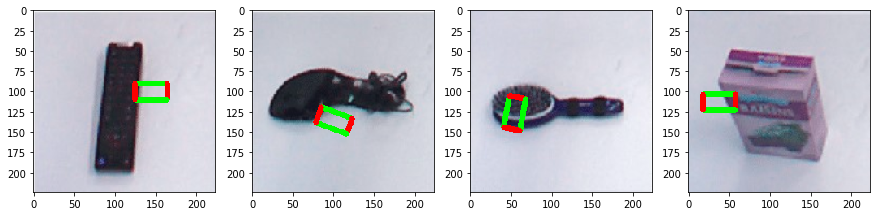

In [9]:
import timeit
import math

start = timeit.default_timer()

index = ['1', '2', '3', '4']
data = []
for name in index:
  img = cv2.imread('/home/isci/ICT-example/third_party/grasp_samplers/demo_images/'+name+'.jpg')[:,:,[2, 1, 0]]
  img = cv2.resize(img, (224, 224))
  data.append(img)

result = []
with torch.no_grad():
  result = run_prediction(data)

stop = timeit.default_timer()
print('Time: ', stop - start) 

plt.clf()
fig , ax = plt.subplots(figsize=(15,15))
for i in range(4):
  plt.subplot(1, 4, i+1)
  plt.imshow(result[i][0][:,:,[2,1,0]])

# [ y, x, theta, noise ]
for i in range(4):
  print(result[i][1])
  assert result[i][1][0] < 255
  assert result[i][1][1] < 255
  assert result[i][1][2] < math.pi
  assert result[i][1][3] < 10
